# Poker Agent V5 - Fixed Training

## Critical Fixes from V3/V4:
1. **Monte Carlo Returns** - Assign final reward to ALL transitions, not just the last one
2. **Proper State Observation** - Agent observes state AFTER opponent acts
3. **Simplified Architecture** - Removed unnecessary LSTM (hands are independent)
4. **Correct Reward Calculation** - Always compute reward from final stack change
5. **Mixed Opponent Training** - Train against all opponent types, not just one at a time

## Architecture:
- Simple DQN with MLP (LSTM removed - no temporal dependencies between hands)
- Per-hand epsilon decay
- Experience replay with complete hand trajectories

In [1]:
# Cell 1: Dependencies & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any

from pokerkit import Automation, NoLimitTexasHoldem, Card

# Constants
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Action Space
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

In [3]:
# Cell 3: Custom Gym Wrapper for PokerKit

class PokerKitGymEnv(gym.Env):
    """Gymnasium wrapper for PokerKit's No-Limit Texas Hold'em."""
    
    def __init__(self, num_players: int = 2, starting_stack: int = 1000, 
                 small_blind: int = 5, big_blind: int = 10):
        super().__init__()
        
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        self.game_state_dim = 52*2 + 52*5 + num_players + 1 + 1 + 4  # 372
        
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.game_state_dim,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        
        self.state = None
        self.agent_player_index = 0
        
    def _card_to_index(self, card: Card) -> int:
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        rank_idx = ranks.index(card.rank)
        suit_idx = suits.index(card.suit)
        return rank_idx * 4 + suit_idx
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _flatten_cards(self, cards) -> List:
        flat = []
        for item in cards:
            if hasattr(item, 'rank'):
                flat.append(item)
            else:
                flat.extend(self._flatten_cards(item))
        return flat
    
    def _get_game_state(self) -> np.ndarray:
        state_vector = []
        
        hole_cards = self._flatten_cards(self.state.hole_cards[self.agent_player_index])
        for i in range(2):
            if i < len(hole_cards):
                state_vector.extend(self._encode_card(hole_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        board_cards = self._flatten_cards(self.state.board_cards)
        for i in range(5):
            if i < len(board_cards):
                state_vector.extend(self._encode_card(board_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        for i in range(self.num_players):
            stack = self.state.stacks[i] / self.starting_stack
            state_vector.append(min(stack, 2.0))
        
        total_pot = sum(self.state.bets)
        state_vector.append(total_pot / (self.starting_stack * self.num_players))
        
        if self.state.actor_index is not None:
            state_vector.append(self.state.actor_index / max(1, self.num_players - 1))
        else:
            state_vector.append(0.0)
        
        street = [0.0, 0.0, 0.0, 0.0]
        num_board = len(board_cards)
        if num_board == 0:
            street[0] = 1.0
        elif num_board == 3:
            street[1] = 1.0
        elif num_board == 4:
            street[2] = 1.0
        else:
            street[3] = 1.0
        state_vector.extend(street)
        
        return np.array(state_vector, dtype=np.float32)
    
    def _get_legal_actions(self) -> List[int]:
        legal = []
        if self.state.can_fold():
            legal.append(ENV_FOLD)
        if self.state.can_check_or_call():
            legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to():
            legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        if action == ENV_FOLD:
            if self.state.can_fold():
                self.state.fold()
            elif self.state.can_check_or_call():
                self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call():
                self.state.check_or_call()
            elif self.state.can_fold():
                self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                min_raise = self.state.min_completion_betting_or_raising_to_amount
                max_raise = self.state.max_completion_betting_or_raising_to_amount
                raise_amount = min(min_raise * 2, max_raise)
                self.state.complete_bet_or_raise_to(raise_amount)
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        while self.state.can_burn_card():
            self.state.burn_card('??')
        while self.state.can_deal_board():
            self.state.deal_board()
        while self.state.can_push_chips():
            self.state.push_chips()
        while self.state.can_pull_chips():
            self.state.pull_chips()
    
    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        
        self.state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        
        while self.state.can_deal_hole():
            self.state.deal_hole()
        
        self._run_automations()
        
        return self._get_game_state(), {'legal_actions': self._get_legal_actions()}
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        self._execute_action(action)
        self._run_automations()
        
        done = self.state.status is False
        
        reward = 0.0
        if done:
            final_stack = self.state.stacks[self.agent_player_index]
            reward = (final_stack - self.starting_stack) / self.big_blind
        
        obs = self._get_game_state()
        info = {
            'legal_actions': self._get_legal_actions() if not done else [],
            'current_player': self.state.actor_index if not done else None
        }
        
        return obs, reward, done, False, info
    
    def get_current_player(self) -> Optional[int]:
        if self.state.status is False:
            return None
        return self.state.actor_index
    
    def get_final_reward(self) -> float:
        """Get final reward based on stack change."""
        return (self.state.stacks[self.agent_player_index] - self.starting_stack) / self.big_blind

In [4]:
# Cell 4: Simple Replay Buffer (stores complete episodes)

class EpisodeReplayBuffer:
    """Replay buffer that stores complete episodes with Monte Carlo returns."""
    
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, transitions: List[Tuple]):
        """Store transitions from a complete episode.
        
        Each transition is: (state, action, reward, next_state, done, legal_actions)
        """
        for t in transitions:
            self.buffer.append(t)
    
    def sample(self, batch_size: int):
        batch = random.sample(list(self.buffer), min(batch_size, len(self.buffer)))
        return batch
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Cell 5: Simple DQN Model (no LSTM - hands are independent)

class SimpleDQN(nn.Module):
    """Simple DQN without LSTM - each hand is independent."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 256, 
                 output_dim: int = NUM_ACTIONS):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [6]:
# Cell 6: Fixed-Strategy Opponents

class ManiacAgent:
    """Always raises/bets when possible, otherwise calls."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        if ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class NitAgent:
    """Always folds when facing aggression, checks otherwise."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        # If facing a bet (fold is an option alongside call), usually fold
        if ENV_FOLD in legal_actions and ENV_CHECK_CALL in legal_actions:
            if random.random() < 0.9:  # 90% fold rate vs bets
                return ENV_FOLD
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class RandomAgent:
    """Randomly selects from legal actions."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        return random.choice(legal_actions)

In [7]:
# Cell 7: DQN Agent

class DQNAgent:
    """Simple DQN Agent - no LSTM since hands are independent."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 256,
                 lr: float = 1e-3, gamma: float = 0.99,
                 epsilon_start: float = 1.0, epsilon_min: float = 0.05,
                 epsilon_decay: float = 0.9995):
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = SimpleDQN(input_dim, hidden_dim).to(device)
        self.target_model = SimpleDQN(input_dim, hidden_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
    
    def select_action(self, state: np.ndarray, legal_actions: List[int], 
                      eval_mode: bool = False) -> int:
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values = self.model(state_t)
        
        q_values = q_values.cpu().numpy().flatten()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions:
            masked_q[a] = q_values[a]
        
        return int(np.argmax(masked_q))
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_step(self, buffer: EpisodeReplayBuffer, batch_size: int = 64) -> Optional[float]:
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        
        states = torch.FloatTensor([t[0] for t in batch]).to(device)
        actions = torch.LongTensor([t[1] for t in batch]).to(device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(device)
        next_states = torch.FloatTensor([t[3] for t in batch]).to(device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(device)
        
        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q values
        with torch.no_grad():
            next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Loss and update
        loss = F.mse_loss(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()

In [8]:
# Cell 8: Training Loop (FIXED)

def train_agent(num_hands: int = 20000, batch_size: int = 64, target_update_freq: int = 500):
    """
    Train the DQN agent with proper reward propagation.
    
    KEY FIXES:
    1. Monte Carlo returns: final reward assigned to ALL transitions in an episode
    2. State observation: capture state AFTER opponent acts
    3. Mixed opponent training: randomly select opponent each hand
    4. Simplified DQN: removed LSTM since hands are independent
    """
    env = PokerKitGymEnv(num_players=2)
    agent = DQNAgent(input_dim=env.game_state_dim)
    buffer = EpisodeReplayBuffer(capacity=50000)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    opponent_names = list(opponents.keys())
    
    rewards_history = []
    loss_history = []
    
    print("Starting training...")
    print(f"Total hands: {num_hands}")
    print()
    
    for hand in range(num_hands):
        # Randomly select opponent each hand for mixed training
        opponent_name = random.choice(opponent_names)
        opponent = opponents[opponent_name]
        
        state, info = env.reset()
        episode_transitions = []
        done = False
        
        # Track pending agent transition to record next_state after opponent acts
        pending_transition = None
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                # If there's a pending transition, the opponent didn't act after us
                # This happens when it's our turn again (e.g., start of new street)
                if pending_transition is not None:
                    episode_transitions.append((
                        pending_transition[0],  # state
                        pending_transition[1],  # action
                        0.0,                    # reward (will be updated at end)
                        state,                  # next_state
                        False,                  # done
                        legal_actions           # next_legal_actions
                    ))
                    pending_transition = None
                
                action = agent.select_action(state, legal_actions)
                pending_transition = (state.copy(), action)
                next_state, reward, done, truncated, info = env.step(action)
                
                if done:
                    # Hand ended on our action - record immediately
                    episode_transitions.append((
                        pending_transition[0],
                        pending_transition[1],
                        0.0,  # Will be updated with final reward
                        next_state,
                        True,
                        []
                    ))
                    pending_transition = None
                
                state = next_state
            else:
                opp_action = opponent.select_action(legal_actions)
                next_state, reward, done, truncated, info = env.step(opp_action)
                
                # FIX: Now we can record the transition with state AFTER opponent acted
                if pending_transition is not None:
                    episode_transitions.append((
                        pending_transition[0],  # state when we acted
                        pending_transition[1],  # our action
                        0.0,                    # reward (will be updated at end)
                        next_state,             # state AFTER opponent acted
                        done,                   # whether hand is done
                        info.get('legal_actions', [])
                    ))
                    pending_transition = None
                
                state = next_state
        
        # FIX: Monte Carlo returns - assign final reward to ALL transitions
        if episode_transitions:
            final_reward = env.get_final_reward()
            rewards_history.append(final_reward)
            
            # Assign reward to all transitions (Monte Carlo style)
            corrected_transitions = []
            for i, t in enumerate(episode_transitions):
                is_last = (i == len(episode_transitions) - 1)
                corrected_transitions.append((
                    t[0],           # state
                    t[1],           # action 
                    final_reward,   # FIX: same reward for all transitions
                    t[3],           # next_state
                    is_last,        # done flag: only True for last transition
                    t[5]            # legal_actions
                ))
            
            buffer.push(corrected_transitions)
        
        # Train
        if len(buffer) >= batch_size:
            loss = agent.train_step(buffer, batch_size)
            if loss is not None:
                loss_history.append(loss)
        
        # Update epsilon per hand
        agent.update_epsilon()
        
        # Update target network
        if hand % target_update_freq == 0 and hand > 0:
            agent.update_target_network()
        
        # Progress logging
        if (hand + 1) % 1000 == 0:
            recent_rewards = rewards_history[-1000:]
            avg_reward = np.mean(recent_rewards)
            print(f"Hand {hand+1}/{num_hands} | Avg Reward (last 1000): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    print("\nTraining complete!")
    
    return agent, rewards_history, loss_history

In [9]:
# Cell 9: Evaluation Function

def evaluate_agent(agent: DQNAgent, num_hands: int = 500, 
                   opponent_type: str = 'random') -> Dict:
    """Evaluate agent against a specific opponent type."""
    env = PokerKitGymEnv(num_players=2)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    opponent = opponents[opponent_type]
    
    wins = 0
    losses = 0
    ties = 0
    total_reward = 0.0
    
    for hand in range(num_hands):
        state, info = env.reset()
        done = False
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                action = agent.select_action(state, legal_actions, eval_mode=True)
            else:
                action = opponent.select_action(legal_actions)
            
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
        
        hand_reward = env.get_final_reward()
        
        total_reward += hand_reward
        if hand_reward > 0:
            wins += 1
        elif hand_reward < 0:
            losses += 1
        else:
            ties += 1
    
    results = {
        'opponent': opponent_type,
        'hands_played': num_hands,
        'wins': wins,
        'losses': losses,
        'ties': ties,
        'win_rate': wins / num_hands,
        'total_reward': total_reward,
        'avg_reward': total_reward / num_hands
    }
    
    print(f"\n=== Evaluation vs {opponent_type.upper()} ===")
    print(f"Hands: {num_hands}")
    print(f"W/L/T: {wins}/{losses}/{ties}")
    print(f"Win Rate: {results['win_rate']:.1%}")
    print(f"Total Profit: {total_reward:.1f} BBs")
    print(f"Avg Profit/Hand: {results['avg_reward']:.2f} BBs")
    
    return results

In [10]:
# Cell 10: Run Training
print("=" * 60)
print("Poker Agent V5 - Fixed Training")
print("=" * 60)
print()
print("Key fixes:")
print("  1. Monte Carlo returns: final reward assigned to ALL transitions")
print("  2. State observation: next_state captured AFTER opponent acts")
print("  3. Simplified DQN: removed LSTM (hands are independent)")
print("  4. Mixed opponent training: random opponent each hand")
print("=" * 60)

agent, rewards_history, loss_history = train_agent(num_hands=20000)

Poker Agent V5 - Fixed Training

Key fixes:
  1. Monte Carlo returns: final reward assigned to ALL transitions
  2. State observation: next_state captured AFTER opponent acts
  3. Simplified DQN: removed LSTM (hands are independent)
  4. Mixed opponent training: random opponent each hand
Starting training...
Total hands: 20000



/tmp/ipykernel_85004/2144593613.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([t[0] for t in batch]).to(device)


Hand 1000/20000 | Avg Reward (last 1000): -11.38 | Epsilon: 0.606
Hand 2000/20000 | Avg Reward (last 1000): -8.03 | Epsilon: 0.368
Hand 3000/20000 | Avg Reward (last 1000): -4.65 | Epsilon: 0.223
Hand 4000/20000 | Avg Reward (last 1000): -3.18 | Epsilon: 0.135
Hand 5000/20000 | Avg Reward (last 1000): -2.81 | Epsilon: 0.082
Hand 6000/20000 | Avg Reward (last 1000): -2.42 | Epsilon: 0.050
Hand 7000/20000 | Avg Reward (last 1000): -2.35 | Epsilon: 0.050
Hand 8000/20000 | Avg Reward (last 1000): -2.13 | Epsilon: 0.050
Hand 9000/20000 | Avg Reward (last 1000): -2.17 | Epsilon: 0.050
Hand 10000/20000 | Avg Reward (last 1000): -2.65 | Epsilon: 0.050
Hand 11000/20000 | Avg Reward (last 1000): -2.07 | Epsilon: 0.050
Hand 12000/20000 | Avg Reward (last 1000): -2.37 | Epsilon: 0.050
Hand 13000/20000 | Avg Reward (last 1000): -2.46 | Epsilon: 0.050
Hand 14000/20000 | Avg Reward (last 1000): -1.87 | Epsilon: 0.050
Hand 15000/20000 | Avg Reward (last 1000): -1.97 | Epsilon: 0.050
Hand 16000/20000 |


TRAINING VISUALIZATION


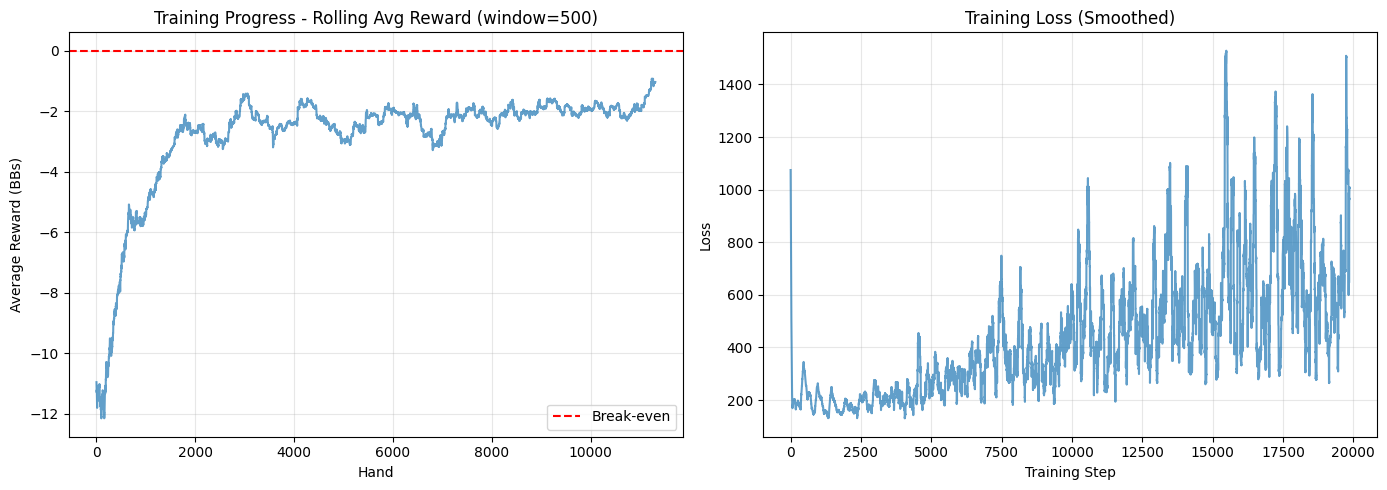


Training plot saved to training_results_v5.png


In [11]:
# Cell 11: Visualize Training
print("\n" + "=" * 60)
print("TRAINING VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rolling average of rewards
window = 500
if len(rewards_history) > window:
    rolling_rewards = np.convolve(rewards_history, np.ones(window)/window, mode='valid')
    axes[0].plot(rolling_rewards, alpha=0.7)
else:
    axes[0].plot(rewards_history, alpha=0.7)
axes[0].axhline(y=0, color='r', linestyle='--', label='Break-even')
axes[0].set_xlabel('Hand')
axes[0].set_ylabel('Average Reward (BBs)')
axes[0].set_title(f'Training Progress - Rolling Avg Reward (window={window})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss history
if loss_history:
    loss_window = 100
    if len(loss_history) > loss_window:
        smoothed_loss = np.convolve(loss_history, np.ones(loss_window)/loss_window, mode='valid')
        axes[1].plot(smoothed_loss, alpha=0.7)
    else:
        axes[1].plot(loss_history, alpha=0.7)
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training Loss (Smoothed)')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results_v5.png', dpi=150)
plt.show()
print("\nTraining plot saved to training_results_v5.png")

In [12]:
# Cell 12: Final Evaluation
print("\n" + "=" * 60)
print("FINAL EVALUATION")
print("=" * 60)

results = {}
for opp in ['random', 'maniac', 'nit']:
    results[opp] = evaluate_agent(agent, num_hands=500, opponent_type=opp)

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
all_positive = True
for opp, r in results.items():
    if opp in ['maniac', 'nit']:  # Only check deterministic opponents
        status = "✓ PASS" if r['avg_reward'] > 0 else "✗ FAIL"
        if r['avg_reward'] <= 0:
            all_positive = False
    else:
        status = "~" if abs(r['avg_reward']) < 1 else ("✓" if r['avg_reward'] > 0 else "✗")
    print(f"{opp.capitalize():10} | Avg: {r['avg_reward']:+.2f} BB/hand | {status}")

print()
if all_positive:
    print("SUCCESS: Agent achieves positive rewards against all deterministic opponents!")
else:
    print("NOTE: Agent still needs improvement against some opponents.")


FINAL EVALUATION

=== Evaluation vs RANDOM ===
Hands: 500
W/L/T: 230/270/0
Win Rate: 46.0%
Total Profit: -259.5 BBs
Avg Profit/Hand: -0.52 BBs

=== Evaluation vs MANIAC ===
Hands: 500
W/L/T: 30/467/3
Win Rate: 6.0%
Total Profit: -1201.0 BBs
Avg Profit/Hand: -2.40 BBs

=== Evaluation vs NIT ===
Hands: 500
W/L/T: 482/17/1
Win Rate: 96.4%
Total Profit: 237.5 BBs
Avg Profit/Hand: 0.47 BBs

SUMMARY
Random     | Avg: -0.52 BB/hand | ~
Maniac     | Avg: -2.40 BB/hand | ✗ FAIL
Nit        | Avg: +0.47 BB/hand | ✓ PASS

NOTE: Agent still needs improvement against some opponents.
